In [1]:
#import libraries
import pandas as pd
import numpy as np

import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

from textblob import Word

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, classification_report,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from lightgbm import LGBMClassifier

import gensim
from gensim.models.word2vec import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
import pickle
import seaborn as sn

import emoji

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/kalit/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Processing Data

In [2]:
# Retrieve data from the given path

filePath = '../data/en_Hasoc2021_train.csv'
filePath = '../../data/english/english_2021.csv'
df1 = pd.read_csv(filePath,delimiter=',')

df1 = df1.drop('task_2',axis=1)
df1.columns = ['TwitterID','HASOCID','Text','Type']
df1 = df1.drop(['TwitterID','HASOCID'],axis=1)

filePath = '../../data/english/english_2020.xlsx'
df2 = pd.read_excel(filePath,engine='openpyxl')

df2 = df2.drop('task2',axis=1)
df2.columns = ['TwitterID','Text','Type','HASOCID']
df2 = df2.drop(['TwitterID','HASOCID'],axis=1)


filePath = '../../data/english/english_2019_1.tsv'
df3 = pd.read_csv(filePath,delimiter='\t')

df3 = df3.drop(['text_id','task_2','task_3'],axis=1)
df3.columns = ['Text','Type']

filePath = '../../data/english/english_2019_2.tsv'
df4 = pd.read_csv(filePath,delimiter='\t')

df4 = df4.drop(['text_id','task_2','task_3'],axis=1)
df4.columns = ['Text','Type']

In [3]:
df = pd.concat([df1,df2,df3,df4])

In [4]:
# Convert target variable to categorical value(integer)

df['Type'] = df['Type'].astype('category')
df['Type'] = df['Type'].cat.codes
df['Type'] = df['Type'].astype(np.int64)

In [5]:
X = df['Text']
Y = df['Type']

In [2]:
def preprocess(txt):
    '''
        - Convert to lower case
        - Remove excessive spaces
        - Remove @handle
        - Remove website links/URLS
        - Search how to incorporate emojis?
    '''
    txt = txt.lower()
    txt = re.sub(r'\s+',' ',txt)
    txt = re.sub(r'@[\w\-]+','',txt)
    txt = re.sub(r'https?:\/\/\S+','',txt)
    txt = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)",'',txt)
    txt = re.sub(r'{link}', '', txt)
    txt = re.sub(r"\[video\]", '', txt)
    txt = re.sub(r'&[a-z]+;', '', txt)
    txt = re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', txt)
    txt = re.sub(r"[^\w\d'\s]+",'',txt)
    return txt

In [3]:
stop_words = stopwords.words('english')

def get_refined_txt(tweet):
    '''
        - Preprocess a given tweet text
        - Tokenize using RegexpTokenizer
        - Lemmatize each token, eg: rocks -> rock, better -> good
        - Remove stop words(or not)?
    '''
    tweet = preprocess(tweet)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(tweet)
    words = [Word(t).lemmatize() for t in tokens]
    words = [w for w in words if not w in stop_words]
    refined_txt = ' '.join(words)
    return refined_txt

In [4]:
txt = '@narendramodi, you are #NotMyPrimeMinister anymore. Your egoistic and populistic ways have no place in #Delhi. Millions are dying because of your inactions and you are focused on ruining Delhi’s heritage. Get out of my city!  #ResignModi https://t.co/GcW74Ccpyz'
ref_txt = get_refined_txt(txt)
print(ref_txt)

notmyprimeminister anymore egoistic populistic way place delhi million dying inaction focused ruining delhi heritage get city resignmodi


In [8]:
def generateNGramValues(X_train,X_test):
    count_vect = CountVectorizer(ngram_range=(1, 3), preprocessor=get_refined_txt)
    X_train_counts = count_vect.fit_transform(X_train)
    X_test_counts = count_vect.transform(X_test)
    return [X_train_counts,X_test_counts,count_vect]

In [9]:
def generateTFIDFValues(X_train_counts,X_test_counts):
    tf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
    X_train_tfidf = tf_transformer.fit_transform(X_train_counts)
    X_test_tfidf = tf_transformer.transform(X_test_counts)
    return [X_train_tfidf, X_test_tfidf,tf_transformer]

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

X_train_counts,X_test_counts,count_vect = generateNGramValues(X_train,X_test)
X_train_tfidf, X_test_tfidf,tf_transformer = generateTFIDFValues(X_train_counts,X_test_counts)

In [11]:
def train_classifier(classifier,parameters,cv_fold=5):
    grid_search = GridSearchCV(classifier,param_grid = parameters,
                               cv = StratifiedKFold(n_splits=cv_fold,
                                                random_state=42,shuffle=True).split(X_train_tfidf,Y_train))
    model = grid_search.fit(X_train_tfidf,Y_train)
    evaluate(model,X_test_tfidf,Y_test)    
    return model

In [12]:
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
    sn.set(font_scale=1.4) 
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})
    plt.show()

In [13]:
def evaluate(model,X_test,Y_test):
  print('Cross Validation Results:')
  print(model.cv_results_)

  y_pred = model.predict(X_test)
  
  print('Classification Report:')
  report = classification_report(Y_test, y_pred)
  print(report)
  plot_confussion_matrix(Y_test,y_pred)

### Logistic Regression Classifier

Cross Validation Results:
{'mean_fit_time': array([0.14425344]), 'std_fit_time': array([0.00369058]), 'mean_score_time': array([0.00189042]), 'std_score_time': array([0.00018787]), 'params': [{}], 'split0_test_score': array([0.74881924]), 'split1_test_score': array([0.75053671]), 'split2_test_score': array([0.73722628]), 'split3_test_score': array([0.75225419]), 'split4_test_score': array([0.72723368]), 'mean_test_score': array([0.74321402]), 'std_test_score': array([0.00957068]), 'rank_test_score': array([1], dtype=int32)}
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72      1377
           1       0.75      0.78      0.76      1535

    accuracy                           0.74      2912
   macro avg       0.74      0.74      0.74      2912
weighted avg       0.74      0.74      0.74      2912



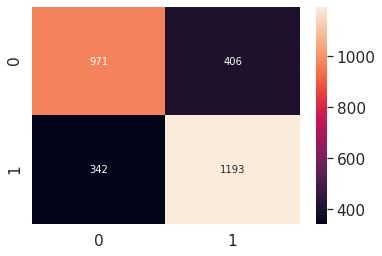

In [14]:
classifier_lr = LogisticRegression(class_weight='balanced',penalty='l2',max_iter=400,
                                solver='liblinear', random_state=42, multi_class='ovr')
classifier_lr = train_classifier(classifier_lr,parameters=[{}],cv_fold=5)

### Support Vector Classifier

Cross Validation Results:
{'mean_fit_time': array([13.46504021, 14.08771653, 14.43147221, 15.05724087, 18.70503373,
       19.07473001, 17.21764145, 18.90692019, 19.16633897, 50.19737353,
       20.02821412, 56.93928709]), 'std_fit_time': array([0.31113696, 0.31768313, 0.30403189, 0.41657056, 1.61489508,
       0.60777625, 0.50466449, 0.31396443, 0.63538396, 0.68519337,
       0.9545106 , 3.48883231]), 'mean_score_time': array([2.89862161, 3.1214663 , 3.161725  , 3.21246939, 3.84811158,
       3.78471909, 3.5986299 , 3.90955815, 3.82396441, 3.90107059,
       4.26812124, 4.35504808]), 'std_score_time': array([0.10541413, 0.13797544, 0.08709031, 0.09028763, 0.24262826,
       0.09164876, 0.13274646, 0.16351541, 0.08373796, 0.20645834,
       0.47603161, 0.2428439 ]), 'param_C': masked_array(data=[0.001, 0.001, 0.001, 0.001, 0.1, 0.1, 0.1, 0.1, 10, 10,
                   10, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, F

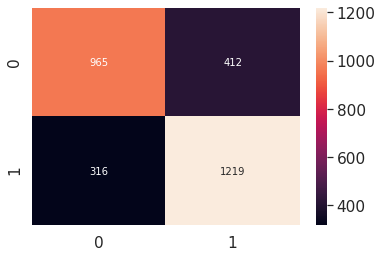

In [15]:
classifier_svc = SVC(kernel='rbf')
params = {'C':[0.001,0.1,10],'gamma':[0.01,0.1,'auto','scale']}
classifier_svc = train_classifier(classifier_svc,parameters=params,cv_fold=5)

### Random Forest Classifier

Cross Validation Results:
{'mean_fit_time': array([ 72.27822642, 153.83630028, 240.21728721,  60.94191966,
       121.15836096, 274.1337091 ]), 'std_fit_time': array([ 4.89498756, 13.30742825, 24.0439882 ,  1.27771765,  2.15650147,
       18.75205061]), 'mean_score_time': array([0.98542447, 2.00018229, 3.35164227, 0.15414662, 0.30793037,
       0.68564777]), 'std_score_time': array([0.0867131 , 0.12591879, 0.20834218, 0.00182866, 0.00526855,
       0.03737044]), 'param_max_features': masked_array(data=['log2', 'log2', 'log2', 'sqrt', 'sqrt', 'sqrt'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[50, 100, 200, 50, 100, 200],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_features': 'log2', 'n_estimators': 50}, {'max_features': 'log2', 'n_estimators': 100}, {'max_features': 'log2', 'n_estimators': 200}

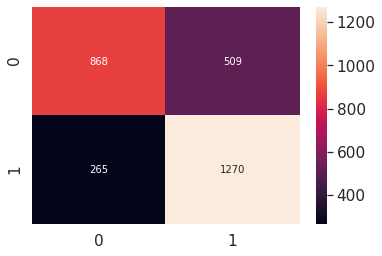

In [16]:
classifier_rf = RandomForestClassifier()
params = {'n_estimators':[50,100,200],'max_features':['log2','sqrt']}
classifier_rf = train_classifier(classifier_rf,parameters=params,cv_fold=5)

### XGBoost Classifier

Cross Validation Results:
{'mean_fit_time': array([4.60327587]), 'std_fit_time': array([0.06617141]), 'mean_score_time': array([0.24712725]), 'std_score_time': array([0.0040166]), 'params': [{}], 'split0_test_score': array([0.72992701]), 'split1_test_score': array([0.72391584]), 'split2_test_score': array([0.73121511]), 'split3_test_score': array([0.73164448]), 'split4_test_score': array([0.72121993]), 'mean_test_score': array([0.72758448]), 'std_test_score': array([0.00422182]), 'rank_test_score': array([1], dtype=int32)}
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      1377
           1       0.72      0.78      0.75      1535

    accuracy                           0.73      2912
   macro avg       0.73      0.72      0.73      2912
weighted avg       0.73      0.73      0.73      2912



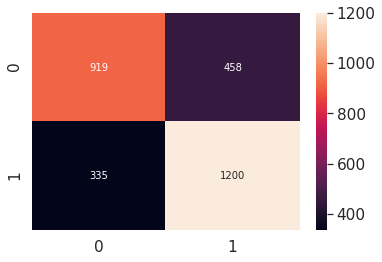

In [18]:
classifier_xg = LGBMClassifier(learning_rate=0.05,n_estimators=1500,
                            colsample_bytree= 0.5,metric = 'f1_score')
classifier_xg = train_classifier(classifier_xg,parameters=[{}],cv_fold=5)

### Predicting outputs

In [17]:
def get_predictions(filePath,model,output_file):
    df_test = pd.read_csv(filePath,delimiter=',')
    
    results = {}

    for ind in df_test.index:
        txt = df_test['text'][ind]
        id = df_test['_id'][ind]

        txt = get_refined_txt(txt)
        txt_cnt = count_vect.transform([txt])
        txt_tfidf = tf_transformer.transform(txt_cnt)

        output = model.predict(txt_tfidf)

        if(output[0]==0):
          results[id] = "HOF"
        else:
          results[id] = "NOT"
        
    df_results = pd.DataFrame(list(results.items()))
    df_results.columns = ["id","label"]
    df_results.to_csv(output_file,index=False)

In [18]:
filePath = '../../data/english/en_Hasoc2021_test_task1.csv'

In [22]:
output_file_path = "../../data/english/classifier_tfidf_ngram_approach_english_lr.csv"
get_predictions(filePath,classifier_lr,output_file_path)

In [23]:
output_file_path = "../../data/english/classifier_tfidf_ngram_approach_english_svc.csv"
get_predictions(filePath,classifier_svc,output_file_path)

In [24]:
output_file_path = "../../data/english/classifier_tfidf_ngram_approach_english_rf.csv"
get_predictions(filePath,classifier_rf,output_file_path)

### Saving models

In [27]:
import joblib

In [28]:
filename = '../../data/english/classifier_tfidf_ngram_approach_english_lr.pkl'
joblib.dump(classifier_lr,filename)

TypeError: can't pickle generator objects

In [29]:
filename = '../../data/english/classifier_tfidf_ngram_approach_english_svc.pkl'
joblib.dump(classifier_svc,filename)

TypeError: can't pickle generator objects

In [30]:
filename = '../../data/english/classifier_tfidf_ngram_approach_english_rf.pkl'
joblib.dump(classifier_rf,filename)

TypeError: can't pickle generator objects